# Scratch Notebook

In [3]:
import sys
import copy
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning")
import json
import collections
import itertools
from functools import partial
import importlib

import numpy as onp
from jax.config import config
config.update("jax_log_compiles", True)
# config.update("jax_enable_x64", True)

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt

import numpy as onp
import jax
import pandas as pd
import haiku as hk
import ot

import config

import utils
import metrics
import time
import plot
from svgd import SVGD
import stein
import kernels
import distributions

from jax.experimental import optimizers

key = random.PRNGKey(0)

from jax.scipy.stats import norm

In [4]:
from kernels import defunnelize
f = distributions.Funnel(2)
s = f.sample(100)

In [17]:
def defunnelize(z):
    """Inverse of funnelize."""
    *x, y = np.asarray(z)
    print(x)
    print(y)
    return x, y


In [18]:
x, y = defunnelize(s[0])

[0.42739016]
-3.084774


In [19]:
x*y

TypeError: can't multiply sequence by non-int of type 'numpy.float32'

In [7]:
vmap(defunnelize)(s)

TypeError: can't multiply sequence by non-int of type 'BatchTracer'

## FunnelizeGaussian

In [2]:
fg = distributions.FunnelizedGaussian([0,0], 1)

In [3]:
s = random.normal(key, (100, 2)) *3

In [4]:
(vmap(fg.pdf)(s) - vmap(fg._pdf)(s)).max()

DeviceArray(1.1920929e-07, dtype=float32)

In [6]:
s = fg.sample(1000)
s.shape

(1000, 2)

(-10.0, 10.0)

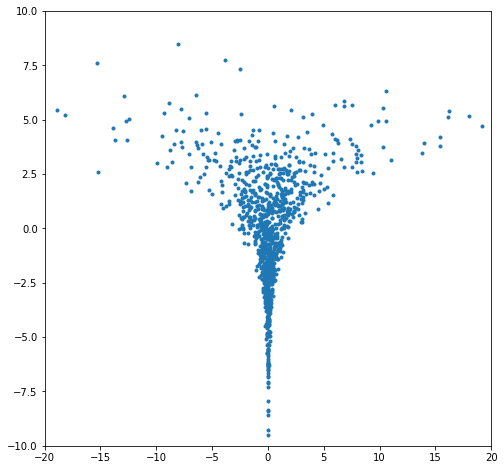

In [7]:
fig, ax = plt.subplots(figsize=[8, 8])
plot.scatter(s, ax=ax, marker=".")
ax.set_xlim((-20, 20))
ax.set_ylim((-10, 10))

In [ ]:
sdkf

## Inheritance and `super`

In [ ]:
class Base():
    def __init__(self):
        self.c = 2
    
    def method(self, x):
        return self.c*x
    
class Sub(Base):
    def __init__(self):
        super().__init__()
        self.c = 10
        
    def method(self, x):
        return self.c*super(Sub, self).method(x)

In [ ]:
test = Sub()
test.method(1)

# kernel is not positive definite

In [ ]:
conf_mlp = copy.deepcopy(config.config)

# conf_mlp["svgd"]["target_args"] = [[0, 5], [1, 3]]
conf_mlp["svgd"]["target"] = "Gaussian Mixture"
conf_mlp["svgd"]["target_args"] = metrics.bent_args

conf_mlp["svgd"]["n_particles"] = 6000
conf_mlp["svgd"]["n_subsamples"] = 100
conf_mlp["svgd"]["lam"] = 1
conf_mlp["svgd"]["encoder_layers"] = [8, 8, 8, 2]
conf_mlp["svgd"]["decoder_layers"] = [8, 8, 4, 1]

conf_mlp["train_kernel"]["ksd_steps"] = 2
conf_mlp["train_kernel"]["svgd_steps"] = 1
conf_mlp["train_kernel"]["n_iter"] = 80 #config.config["train_kernel"]["n_iter"] // conf_mlp["train_kernel"]["svgd_steps"]
conf_mlp["train_kernel"]["optimizer_ksd_args"] = [0.03]
conf_mlp["train_kernel"]["lamda_reg"] = 1e-2

In [ ]:
s = SVGD(**config.get_svgd_args(conf_mlp))

In [ ]:
params, rundata = s.train_kernel(key, **config.get_train_args(conf_mlp))

In [ ]:
plt.plot(rundata["ksd_before_kernel_update_val"])
plt.yscale("log")

In [ ]:
d = distributions.GaussianMixture(*conf_mlp["svgd"]["target_args"])
k = kernels.get_rbf_kernel_logscaled(logh=0)
# k = lambda x, y: np.dot(x, y)
# k = s.get_kernel_fn(params)

In [ ]:
eps = 1e-6
n = 100
x = d.sample(n)
gram = vmap(vmap(k, (0, None)), (None, 0))(x, x)
gram_reg = gram + eps * np.identity(n)
print("gram PD:", utils.is_pd(gram))
print("regularized gram PD:", utils.is_pd(gram_reg))

In [ ]:
vals, vecs = np.linalg.eig(gram)
vals = np.asarray(vals, dtype=np.float32)

vals_reg, _ = np.linalg.eig(gram_reg)
vals_reg = np.asarray(vals_reg, dtype=np.float32)

In [ ]:
np.min(vals)

In [ ]:
np.min(vals_reg)

## mixture

In [ ]:
def f(key): return random.normal(key)
def g(key): return random.normal(key) + 30

mix = utils.mixture([f, g], [0.2, 0.8])

In [ ]:
x = []
for key in random.split(key, 1000):
    x.append(mix(key))

In [ ]:
_ = plt.hist(x, bins=100)

In [ ]:
key, subkey = random.split(key)
random.randint(subkey, shape=(1,), minval=0, maxval=2)

# Interesting target dists

In [ ]:
l = np.asarray((1, 2, 1.5, 3, 3.3, 3.8))
l = onp.concatenate([-l, [0], l])
means = list(zip(l, (l**2)**0.8))
variances = [[1,1]]*len(means)
weights = [1]*len(means)
target = distributions.GaussianMixture(means, variances, weights)

In [ ]:
plot.plot_pdf(target.pdf, (-10, 10), "contour")

In [ ]:
plot.bivariate_hist(target.sample(100))

# Test variance of KSD estimators
compare U-estimator with linear time estimator

In [ ]:
target = distributions.Gaussian(0, 1)
source = distributions.Gaussian(0, 1)
kernel = kernels.get_rbf_kernel_logscaled(logh=0)

# estimate variance

In [ ]:
L = 10 # linear time estimator uses L2n samples --> memory L2n, computation Ln, Var(KSD_L) = 1/Ln Var(h(X, Y))
      # where n = nr of samples for U-estimator

In [ ]:
def sample_ksd(n, source, target, mode="l"):
    if mode=="u":
        samples = source.sample(n)
        return stein.ksd_squared_u(samples, target.logpdf, kernel)
    elif mode=="l":
        samples = source.sample(2*n).split(2)
        return stein.ksd_squared_l(*samples, target.logpdf, kernel, False)
    else:
        raise ValueError("mode must be 'u' or 'l'.")

# @partial(jit, static_argnums=range(5))
def sample_ksd_variance(n, m, source, target, mode="l"):
    return np.var(np.asarray([sample_ksd(n, source, target, mode) for _ in range(m)]))

In [ ]:
m = 100
vars_u = []
vars_l = []
ngrid = 2**onp.arange(5, 10)

for n in ngrid:
    print(n)
    vars_u.append(sample_ksd_variance(n, m, source, target, "u"))
    vars_l.append(sample_ksd_variance(L*n, m, source, target, "l"))

In [ ]:
vars_u, vars_l = [np.asarray(x) for x in (vars_u, vars_l)] 

if not np.all(vars_l / vars_u < 1):
    print("Variance is too high!!")

In [ ]:
plt.plot(ngrid, vars_l / vars_u, ".")
plt.xscale("log")

In [ ]:
vars_l

In [ ]:
vars_u

In [ ]:
m = 1000000
samples = source.sample(m).split(2)
hvar = stein.h_var(*samples, target.logpdf, kernel)
hvar

plt.plot(ngrid, ngrid * L * vars_l, label="V_L in practice")
plt.hlines(hvar, xmin=0, xmax=ngrid[-1], label="V_L in theory")
# plt.yscale("log")
plt.xscale("log")
plt.legend()

In [ ]:
plt.plot(ngrid, ngrid * vars_u, ".")
plt.xscale("log")

# does jit cache intermediate computations, if useful?

Answer: yes! But: you don't get around memory constraints (e.g. three nested `vmap`s are always gonna need $n^3$ memory, even if output is a scalar).

In [ ]:
def means(xs):
    compute = [np.mean(xs) for _ in range(100)], [np.mean(xs*2)/2 for _ in range(100)]
    return np.asarray(compute)
jitmeans = jit(means)
@jit
def single_mean(xs): return np.mean(xs)

In [ ]:
times = []
jittimes = []
basetimes = []

grid = 2**np.arange(3)
for n in grid:
    key, subkey = random.split(key)
    xs = random.normal(subkey, (n,))
    
    time = %timeit -o means(xs).block_until_ready()
    jittime = %timeit -o jitmeans(xs).block_until_ready()
    base = %timeit -o single_mean(xs).block_until_ready()

    times.append(time.best)
    jittimes.append(jittime.best)
    basetimes.append(base.best)

In [ ]:
plt.plot(grid, jittimes, ".", label="jitted")
plt.plot(grid, times, ".", label="normal")
plt.plot(grid, basetimes, ".", label="single mean")

plt.xscale("log")
plt.yscale("log")
plt.legend()

In [ ]:
slkfj

In [ ]:
def test(x):
    n = 1000
    xs = np.repeat(x, n)
    idv = vmap(lambda x: x)
    idvv = vmap(idv)
    idvvv = vmap(idvv) now id takes argument of shape (n, n, n)
    return 

In [ ]:
# def h(x, y): return np.exp(np.sum((x - y)**2))
# def h_thrice(x, y, z): return h(x, y) * h(x, y) * h(y, z)
def h_thrice(x, y, z): return x+y+z


def test(xs):
    """In theory, to compute this it would suffice to compute x + y for all x, y in xs.
    Store those in an nxn matrix. """
    hv   = vmap(h_thrice, (0, None, None))
    hvv  = vmap(hv,       (None, 0, None))
    hvvv = vmap(hvv,      (None, None, 0))
    return np.mean(hvv(xs, xs, xs))

jittest = jit(test)

In [ ]:
n = 100
xs = random.normal(key, (n,))
test(xs)

In [ ]:
(2**11)**3 * 4 / 10**6

In [ ]:
(2**11)**2 * 4 / 10**6

In [ ]:
hk.data_structures.tree_bytes(xs)

In [ ]:
xs.shape

In [ ]:
times = []
jittimes = []

num_reps = 50
# grid = [3, 5, 10, 20, 50, 100, 200, 300]
grid = 2**np.arange(13)
for n in grid:
    key, subkey = random.split(key)
    xs = random.normal(subkey, (n,))
    
#     time = %timeit -o test(xs).block_until_ready()
    jittime = %timeit -o jittest(xs).block_until_ready()
    
#     times.append(time.best)
    jittimes.append(jittime.best)

In [ ]:
plt.plot(grid, jittimes, ".", label="jitted")
plt.plot(grid, times, ".", label="normal")
plt.xscale("log")
plt.yscale("log")
plt.legend()

In [ ]:
sldfj

# more sampling stuff

In [ ]:
n = 10**2
key, subkey = random.split(key)
x = random.normal(subkey, (n,))

In [ ]:
normalization_factor = np.sum(norm.pdf(x))
weights = norm.pdf(x) / normalization_factor

In [ ]:
np.mean(x**2 * weights)

In [ ]:
np.mean(x**2)

## When is stuff zero?

In [ ]:
n = 10**6
key, subkey = random.split(key)
x = random.normal(subkey, (n,))

np.any(jax.scipy.stats.norm.pdf(x) == 0)